# Membuat Model Klasifikasi Rambu Lalu Lintas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
training_file="/content/drive/My Drive/Colab Notebooks/german-traffic-sign/train.p"
testing_file="/content/drive/My Drive/Colab Notebooks/german-traffic-sign/test.p"

Mounted at /content/drive


In [3]:
# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


# Eksplorasi Data

In [4]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/german-traffic-sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [5]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


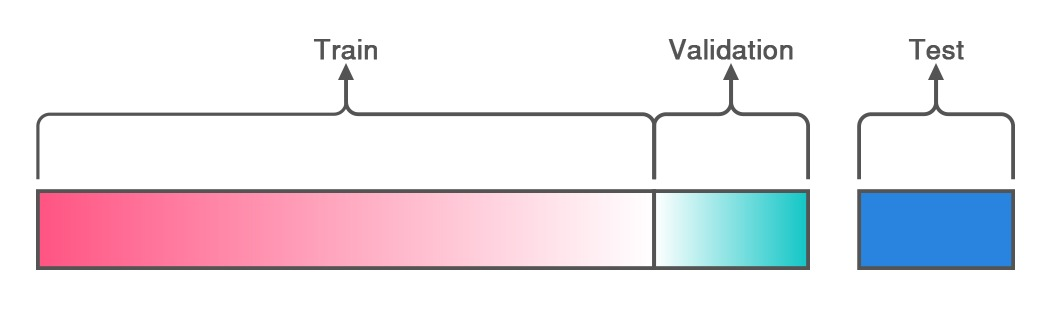

In [6]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


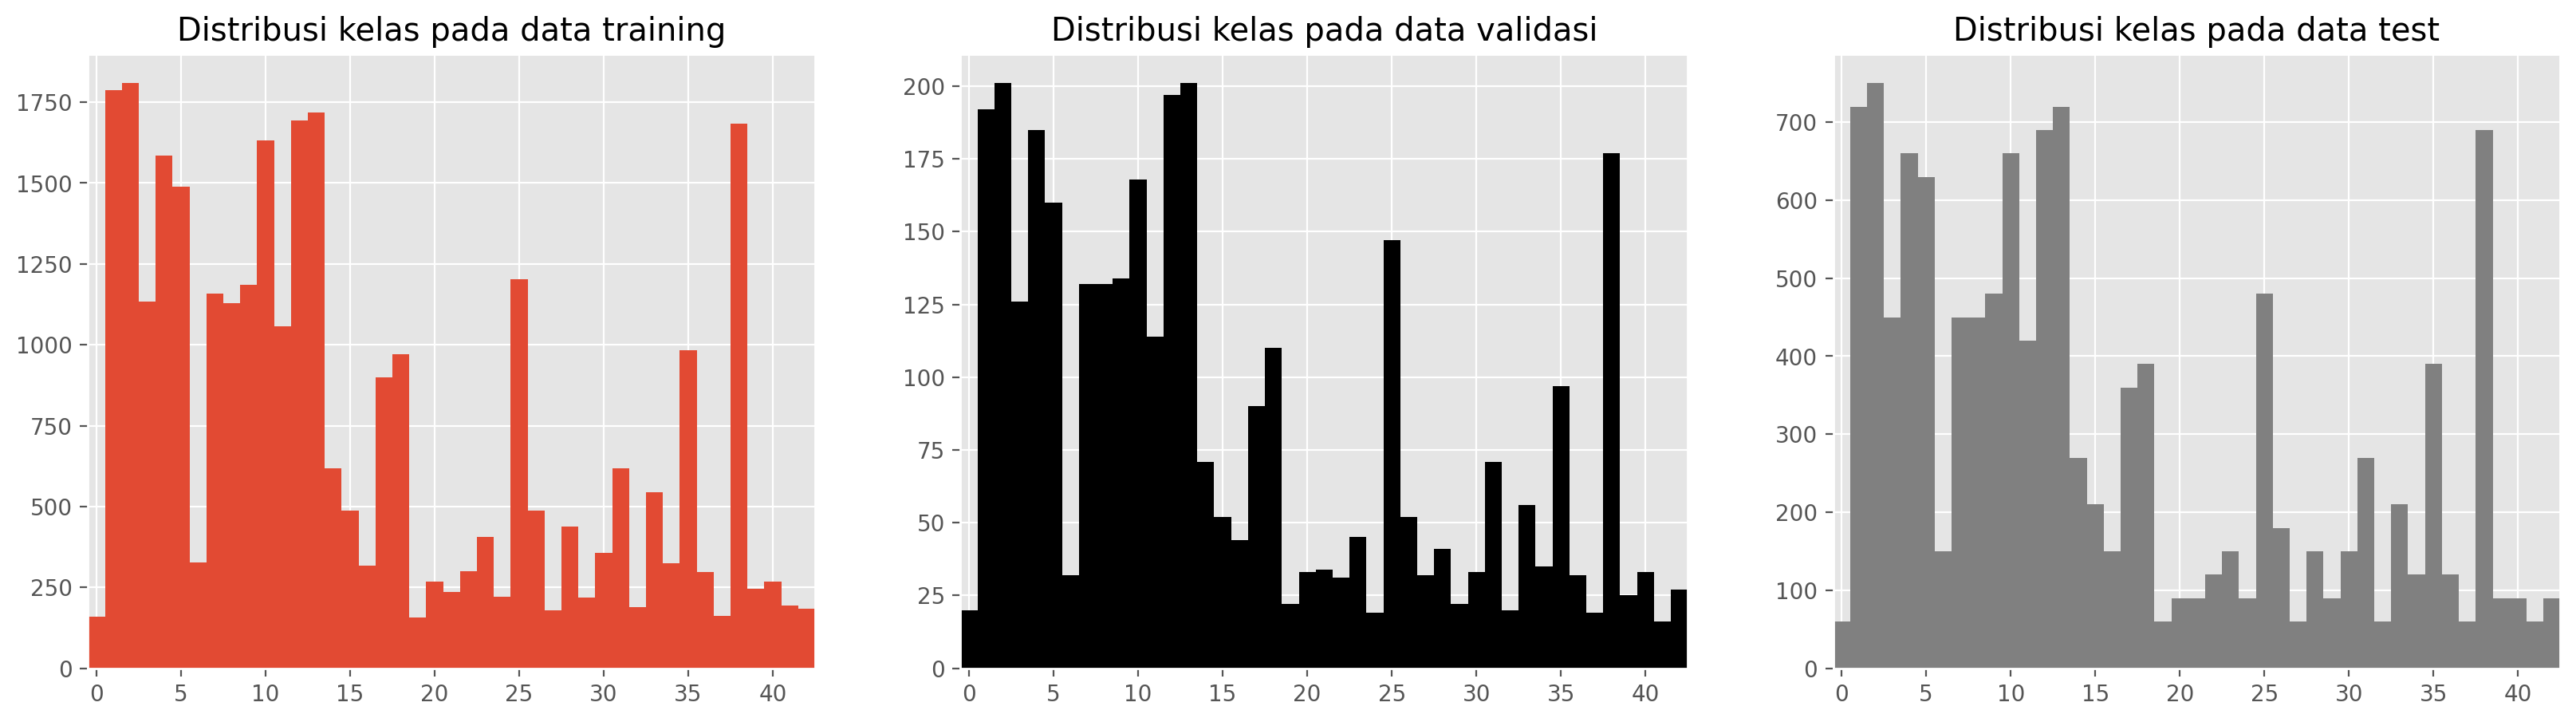

In [7]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [8]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# Training dengan Convolutional Neural Network

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

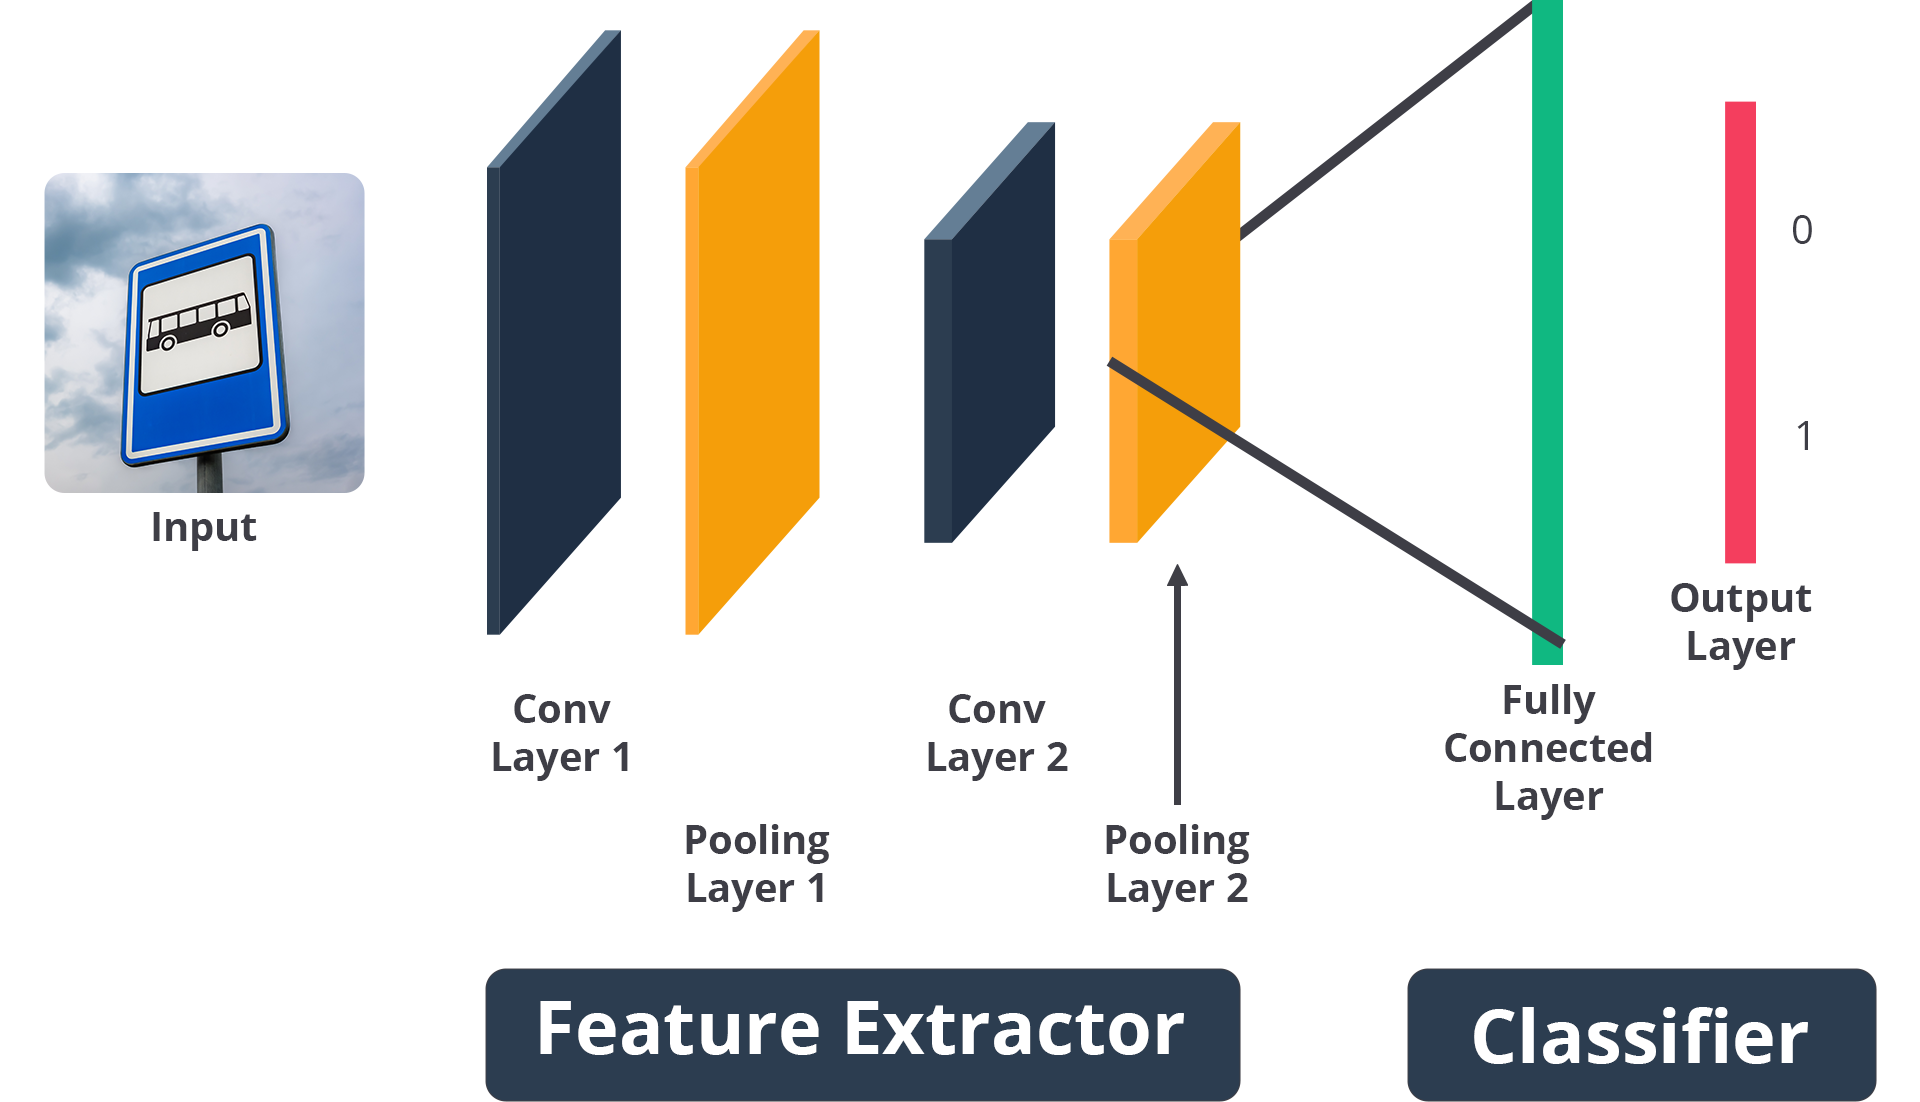

Mari kita ingat kembali sebuah arsitektur Convolutional Network sederhana yang memiliki arsitektur lapisan (layer) Input-Convolutional-RELU-Pooling-FC. Berikut uraiannya:

- Lapisan Input akan menampung gambar sebagai array 3D dari nilai piksel.


- Lapisan Convolutional (konvolusi) akan menghitung perkalian (dot product) antara kernel dan sub-array dari gambar input yang berukuran sama dengan kernel. Sebagai contoh pada gambar berikut kita menggunakan kernel berukuran 3x3 dan melakukan proses perkalian antara kernel dan sub-array pada gambar masukan.
Matriks kernel akan melintasi setiap piksel pada gambar secara berurutan dari kiri ke kanan dan atas ke bawah. Ia menghitung nilai output untuk setiap piksel yang dilintasi kernel dengan teknik perkalian matriks dot product. Kemudian, semua nilai yang dihasilkan dari proses perkalian dot product ini akan menjadi nilai piksel tunggal dari gambar keluaran. Proses ini diulang sampai seluruh gambar input terlewati oleh kernel.

- RELU atau Rectified Linear Activation Unit merupakan fungsi aktivasi linear untuk jaringan saraf tiruan. Ia telah menjadi fungsi aktivasi default karena model yang menggunakannya mencapai kinerja lebih baik dengan cepat.

Ingatlah, fungsi aktivasi digunakan untuk memetakan hasil penjumlahan antara bobot dengan masukan (disebut sebagai weighted sum) menjadi nilai tertentu. Fungsi ini memungkinkan perceptron dapat menyesuaikan pola untuk data non linear.

Nah, jika weighted sum ini bernilai positif, RELU akan mengembalikan nilainya secara langsung. Sebaliknya, jika nilainya negatif, RELU akan menghasilkan nilai nol. RELU didefinisikan sebagai:

f(x) = max(0, x), dengan x adalah jaringan saraf masukan (weighted sum).

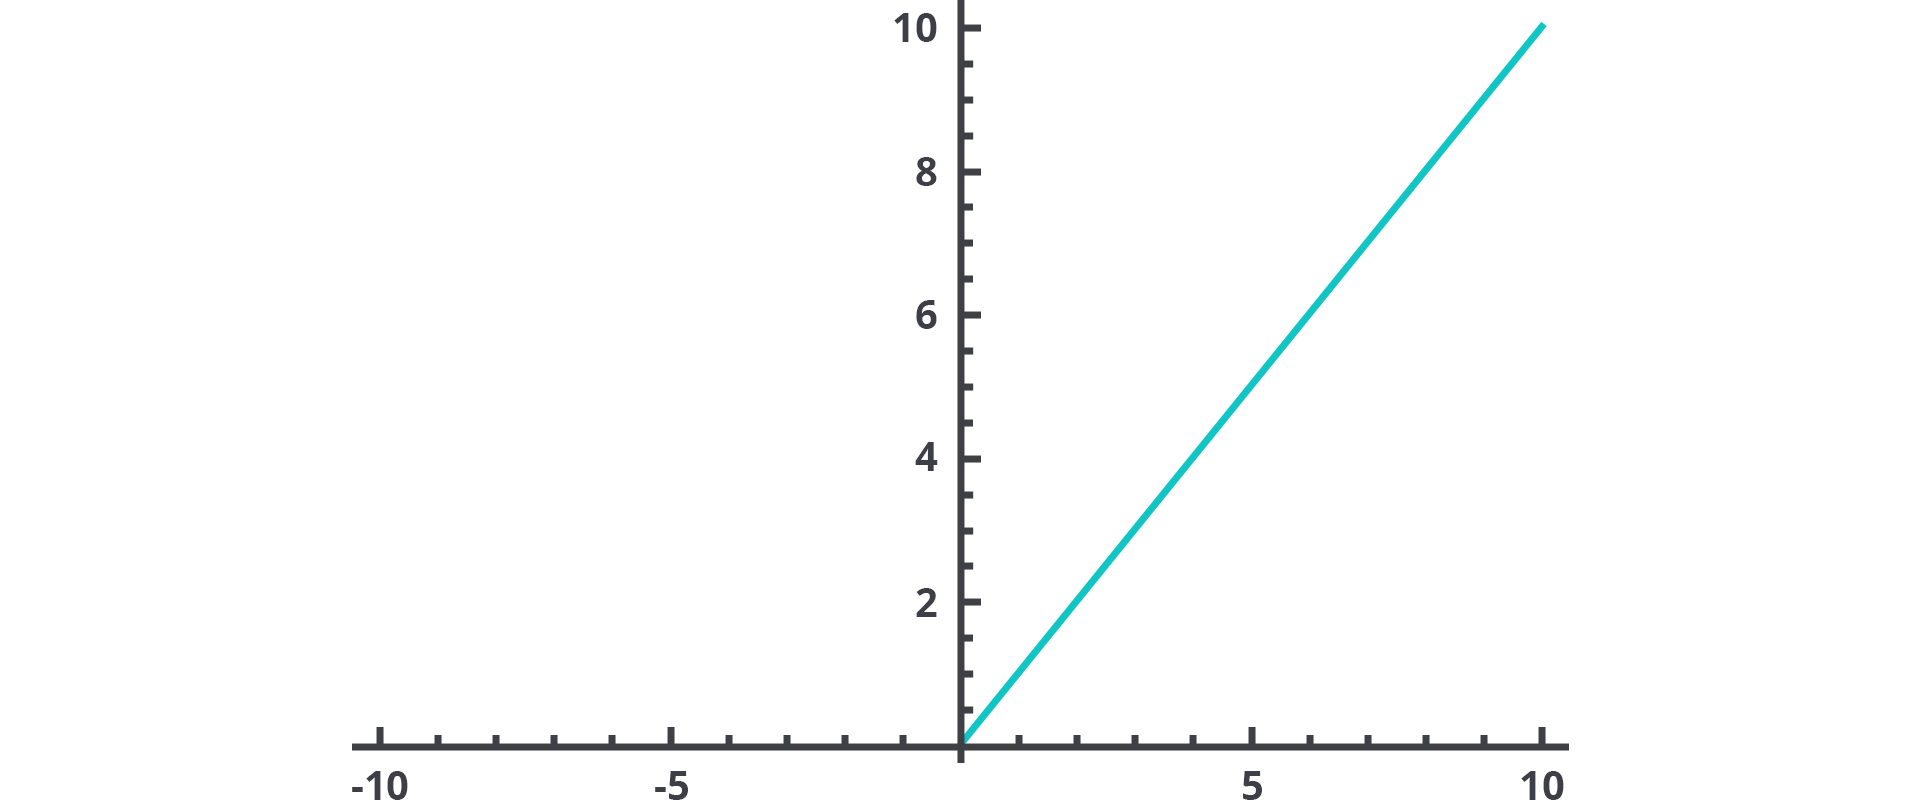

- Lapisan Pooling akan melakukan downsampling pada shape suatu gambar sehingga mengakibatkan pengurangan dimensi gambar. Tujuannya adalah agar data komputasi yang dibutuhkan untuk memproses citra menjadi berkurang.

Pooling layer terdiri dari dua jenis, average pooling dan max pooling. Pada max pooling, setiap area dengan luas piksel tertentu akan diambil satu buah piksel yang memiliki nilai tertinggi. Sementara pada average pooling, nilai yang diambil adalah nilai rata-rata dari suatu area kernel. Untuk lebih jelasnya, mari kita perhatikan gambar berikut.

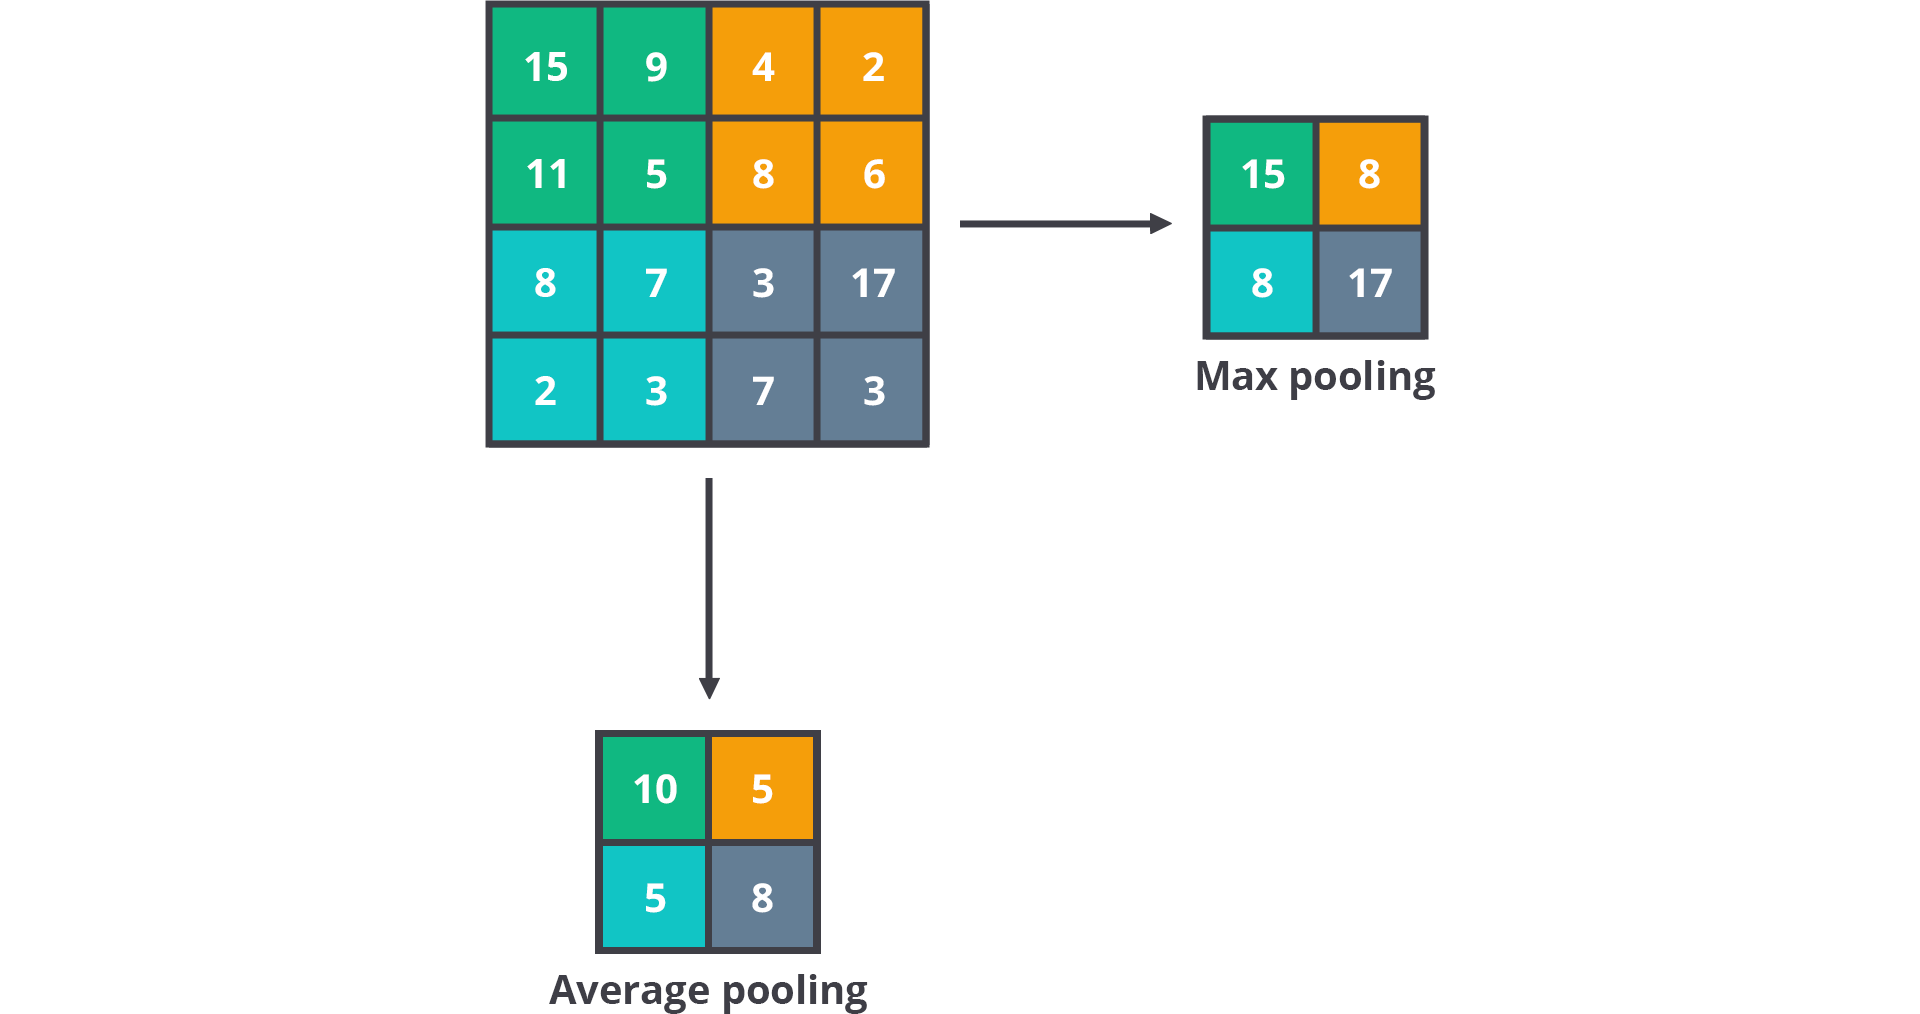

Lapisan pooling juga bertindak sebagai pengendali noise (gangguan). Namun, max pooling memiliki kinerja lebih baik dibanding dengan average pooling. Oleh karena itu, max pooling lebih sering digunakan pada proses training CNN. Kita juga akan menggunakannya dalam proyek ini.
- Lapisan FC (Fully-Connected) akan menghitung skor kelas untuk setiap kategori klasifikasi. Lapisan ini sama dengan jaringan saraf di mana setiap neuron terhubung ke semua neuron pada lapisan secara berurutan. Output akhir dihitung menggunakan softmax yang memberikan probabilitas setiap kelas untuk fitur yang diberikan.

Untuk melewatkan gambar masukan ke lapisan FC, kita perlu melakukan proses flatten sehingga semua nilai piksel diatur dalam satu kolom. Flatten adalah proses mengubah data menjadi array 1 dimensi untuk dimasukkan ke lapisan berikutnya. Kita membuat output dari lapisan konvolusi menjadi satu vektor fitur yang panjang (flat). Kemudian, fitur yang telah melewati proses flatten diteruskan ke lapisan FC.

Pada proyek ini, kita menggunakan arsitektur 2 convolutional layer dan 1 fully connected layer. Untuk lebih jelasnya, mari kita bahas setiap layernya.

Pertama, inisialisasi model Sequential dan tentukan input shape untuk model. Set layer ini menggunakan kernel berukuran 5x5 untuk mempelajari fitur pada data traffic sign. Input masukan kita sesuaikan dengan shape X_train yaitu sebuah gambar RGB berukuran 32 pixels (32, 32, 3). Fungsi aktivasi yang akan kita gunakan adalah RELU, seperti yang telah dijelaskan sebelumnya. Max Pooling layer juga kita tambahkan untuk mengurangi dimensi.

Di sini, kita juga menerapkan dropout. Dropout merupakan salah satu hyperparameter yang bertujuan untuk mengurangi overfitting. Ia bekerja dengan memutus atau menjatuhkan (drop) unit selama proses training neural network sehingga layer atau lapisannya menjadi tidak aktif. Berdasarkan dokumentasi dari Keras, argumen rate untuk dropout adalah tipe data float antara 0 dan 1, yang merupakan bagian dari unit yang akan di-drop.

Jika kita set dropout rate = 0.25, artinya, kita akan melepas 25% dari layer dan membuatnya menjadi tidak aktif selama proses training.

Berikut set layer kita yang pertama. Pada arsitektur ini, set parameter layer sebagai berikut:

- Ukuran filter untuk proses konvolusi=32
- Ukuran kernel=(5,5)
- Fungsi aktivasi RELU
- Pooling yang kita gunakan adalah Maxpool dengan ukuran 2,2
- Dropout rate sebesar 0.25

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

Selanjutnya, untuk layer kedua, gunakan arsitektur sebagai berikut.

In [11]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Kali ini, Anda tentu bisa langsung memahami arsitektur layer dan parameter yang digunakan pada layer kedua. Mari kita lanjut ke bagian fully connected layer.

In [12]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

Pada bagian ini, kita juga menerapkan Dense layer. Dense layer merupakan lapisan saraf yang menerima input dari semua neuron pada lapisan sebelumnya. Menurut dokumentasi keras, lapisan ini mengimplementasikan operasi matriks antara (activation(dot(input, kernel) + bias). Fungsi aktivasi merupakan argumen untuk mendefinisikan fungsi aktivasi yang kita gunakan, dalam hal ini RELU. Sedangkan bias adalah vektor yang dibuat oleh layer dan hanya akan aktif jika kita definisikan sebelumnya (use_bias=true).

Itulah arsitektur jaringan saraf yang akan kita gunakan pada proyek ini. Arsitektur lengkapnya dapat dilihat sebagai berikut.

In [13]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

Selanjutnya, kita akan melakukan kompilasi model dan memanggil fungsi fit untuk memulai training. Implementasikan kode berikut.

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 21s 7ms/step - loss: 1.6978 - accuracy: 0.5644 - val_loss: 0.4322 - val_accuracy: 0.9009
Epoch 2/25
979/979 [==============================] - 5s 5ms/step - loss: 0.6175 - accuracy: 0.8143 - val_loss: 0.2060 - val_accuracy: 0.9491
Epoch 3/25
979/979 [==============================] - 6s 6ms/step - loss: 0.4456 - accuracy: 0.8674 - val_loss: 0.1509 - val_accuracy: 0.9635
Epoch 4/25
979/979 [==============================] - 6s 6ms/step - loss: 0.3693 - accuracy: 0.8913 - val_loss: 0.1034 - val_accuracy: 0.9704
Epoch 5/25
979/979 [==============================] - 7s 8ms/step - loss: 0.3287 - accuracy: 0.9006 - val_loss: 0.1047 - val_accuracy: 0.9649
Epoch 6/25
973/979 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.9117

Perbedaan hasil ini bisa jadi disebabkan oleh perilaku dan kinerja algoritma machine learning yang bersifat stokastik. Deep neural network dilatih menggunakan algoritma optimasi penurunan gradien stokastik. Stokastik di sini mengacu pada proses yang melibatkan beberapa situasi acak (random) dan ketidakpastian (uncertainty). Sifat stokastik pada algoritma machine learning adalah konsep dasar yang penting dan harus dipahami oleh para praktisi machine learning. Tujuannya, agar kita dapat menafsirkan perilaku banyak model prediktif secara efektif.

Terakhir, untuk mendapatkan grafik akurasi dan loss, terapkan kode berikut.

In [ ]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Oke, mari kita lanjutkan ke proses testing.

# Testing Model

Pada tahap eksplorasi data, kita membagi data menjadi tiga bagian, yaitu data training, validasi, dan testing. Setelah memperoleh hasil pada data training dan validasi, kita akan menguji model pada data yang belum pernah dilihat sebelumnya, yaitu data testing. Untuk mengujinya, implementasikan kode berikut.

In [ ]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

95.7% akurasi! Mirip dengan hasil akurasi yang diperoleh pada tahapan training. Artinya, model kita dapat menyesuaikan (fit) pada data baru dengan baik.

Selanjutnya, untuk memperoleh metrik klasifikasi lain seperti precision, recall, dan f1-score, mari kita terapkan fungsi classification_report dari library sklearn.

In [ ]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

Jika diperhatikan pada hampir semua kelas, akurasi precision, recall, dan f1-score memiliki angka yang tinggi, rata-rata di atas 90-an. Namun, pada beberapa kelas seperti kelas dengan indeks 27 dan 42, akurasi rata-ratanya berada dibawah 80%. Hal ini bisa disebabkan oleh representasi fitur yang cukup kompleks dari kedua kelas ini.

Yay! Anda telah berhasil membuat model untuk mengklasifikasikan rambu lalu lintas! Bagaimana? Semakin tertarik untuk belajar mengenai computer vision? Yuk, kita lanjut ke materi berikutnya!

# Teknik-teknik Object Detection

## Pendekatan Klasik
- Haar Cascade
Teknik ini dikenalkan oleh Viola dan Jones. Mereka sering disebut sebagai pelopor deteksi objek. Pada tahun 2001, Viola dan Jones memperkenalkan framework object detection pertama untuk real-time face detection yang dikenal sebagai Haar Cascade.

Bagaimana Haar Cascade bekerja? Kita akan membahasnya lebih detail pada materi selanjutnya.

Sebagai gambaran umum, mari kita ingat kembali saat membahas teknik konvolusi pada materi sebelumnya. Teknik konvolusi menghitung dot product antara matriks kernel dan sub-array dari gambar input. Matriks kernel akan melintasi setiap piksel pada gambar secara berurutan dari kiri ke kanan dan atas ke bawah. Nah, cara ini juga digunakan dalam proses deteksi objek pada gambar. Teknik ini disebut sebagai teknik sliding window

Awalnya, Viola dan Jones fokus pada pendeteksian wajah dalam gambar. Namun, framework ini dapat digunakan untuk melatih deteksi benda lain seperti tubuh manusia, mobil, bangunan, bahkan peralatan dapur.

Salah satu keunggulan teknik ini adalah ia sangat cepat dan efektif. Selain itu, algoritma ini mampu berjalan secara real-time, sehingga memungkinkan kita untuk mendeteksi objek dalam streaming video. Kekurangan dari algoritma ini adalah rentan terhadap hasil prediksi false-positive. Haar Cascade kadang mendeteksi wajah pada gambar padahal sebenarnya tidak ada.

Haar Cascade merupakan algoritma deteksi wajah berbasis fitur yang telah berhasil digunakan selama beberapa dekade. Meskipun Haar Cascade terbilang cukup tua, tetapi algoritma ini cukup relevan dan masih digunakan hingga sekarang.

- Histogram of Oriented Gradients
Metode Histogram of Oriented Gradients --dikenal sebagai HOG, pertama kali dipublikasikan oleh Dalal dan Triggs pada tahun 2005 dalam paper yang berjudul Histogram of Oriented Gradients for Human Detection [46]. Ia merupakan metode untuk mendeteksi gambar menggunakan feature descriptor dan algoritma Support Vector Machine Classifier. Feature descriptor adalah representasi gambar yang hanya mengekstrak informasi (fitur) berguna dan mengabaikan informasi yang tidak berguna. Nah, proses ekstraksi informasi ini dilakukan dengan memeriksa tepi dan sudut pada gambar untuk mengidentifikasi perubahan intensitas atau warna gambar.

Algoritma ini menggunakan teknik sliding window untuk klasifikasi dan lokalisasi objek. Pada setiap langkah sliding window, fitur HoG diekstraksi dan diteruskan ke Support Vector Machine untuk proses klasifikasi objek.

Berikut adalah contoh gambar masukan dan gambar keluaran dari teknik HOG
